In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import sys

sys.path.insert(0, "./interactive_tutorials")

import pandas as pd
# from arango import ArangoClient
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools
import requests
import sys
import oasis
from arango import ArangoClient
from pyArango.connection import Connection

import torch
import torch.nn.functional as F
from torch.nn import Linear
from arango import ArangoClient
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from sentence_transformers import SentenceTransformer
from torch_geometric.data import HeteroData
import yaml

print(torch.__version__)

2.2.1+cu121
2.2.1+cu121


### We load in our reviews. This csv was generated thru categorizer.ipynb - the categories are llama3 predicted based on review title + text.
Currently, organized_reviews is a small sample (6100/~580000) of rows from the source. There seems to be some internal sorting based on category (e.g. first 5 items are all food) which may bias. 
TODO: Change to random sampling

In [2]:
#TODO implement weighting for helpfulness_score
metadata_path = './amazon_data_source/organized_reviews.csv'
df = pd.read_csv(metadata_path)

df.head()
#

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,category,subcategory
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Pet,Food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Food,Snack
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Candy,Treat
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Food,Beverage
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Food,Candy


In [3]:
df.columns
print("There are ",df['ProductId'].nunique()," unique products")
print("And reviews from",df['UserId'].nunique(), "unique users")
print("The average review score is", df['Score'].mean())

There are  941  unique products
And reviews from 5844 unique users
The average review score is 4.17672131147541


There are 941 unique 

In [4]:
df['ProductId'] = df['ProductId'].astype(str)

In [5]:
reviews_df = df[['ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text', 'category', 'subcategory']]
reviews_df.columns = ['product_id', 'user_id', 'username', 'rating', 'review_title', 'review_content', 'category', 'subcategory']
reviews_df = reviews_df.sort_values('product_id')
reviews_df.reset_index(drop=True, inplace=True)

reviews_df['username'] = reviews_df['username'].fillna('unknown')
reviews_df['review_title'] = reviews_df['review_title'].fillna('')
reviews_df['rating'] = reviews_df['rating'].astype(int) 
reviews_df.tail()

,product_id,user_id,username,rating,review_title,review_content,category,subcategory
6095,B009HINRX8,ADDBLG0CFY9AI,S.A.D.,5,Best of the Tassimo's,We've tried many Tassimo flavors. This is by ...,Home,Goods
6096,B009HINRX8,ATNQNZEHWMR9U,Kokopelli,3,Note: Rating both coffee and seller,"This coffee is good but, for me, it's nothing ...",Food,Beverage
6097,B009HINRX8,A2CAZG1CQ8BQI5,Patricia J. Nohalty,5,Kona for Tassimo,Of all the coffee's available for Tassimo this...,Electronics,Homebrewed
6098,B009UOFU20,AJVB004EB0MVK,D. Christofferson,1,weak coffee not good for a premium product and...,"This coffee supposedly is premium, it tastes w...",Home,Supplies
6099,B009WSNWC4,AMP7K1O84DH1T,ESTY,5,DELICIOUS,Purchased this product at a local store in NY ...,Food,Snack


In [6]:
#indexes by product_id
indices = pd.Series(reviews_df.index, index=reviews_df['product_id']).drop_duplicates()

In [7]:
print(reviews_df.dtypes)

product_id        object
user_id           object
username          object
rating             int32
review_title      object
review_content    object
category          object
subcategory       object
dtype: object


In [8]:
def node_mappings(df, index_col):
    mapping = {index: i for i, index in enumerate(df[index_col].unique())}
    return mapping

def create_reverse_mapping(mapping):
    return {emb_id: user_id for user_id, emb_id in mapping.items()}

In [9]:
user_mapping = node_mappings(reviews_df, index_col='user_id')
rev_user_mapping = create_reverse_mapping(user_mapping)

In [10]:
product_mapping = node_mappings(reviews_df, index_col='product_id')

In [11]:
from itertools import islice


for key, value in islice(product_mapping.items(), 20):
    print(key, value)
for key, value in islice(user_mapping.items(), 20):
    print(key, value)

B00002NCJC 0
B00002Z754 1
B000084DVR 2
B000084E1U 3
B0000CERHH 4
B0000CGFV4 5
B0000D94SZ 6
B0000DC5IY 7
B0000E65W9 8
B0000GGI00 9
B0000TU8EO 10
B0000VLH8S 11
B0000VMBDI 12
B0001217OA 13
B00015BQB6 14
B00016UX0K 15
B0001E3LBU 16
B0001FQVCK 17
B0001KL1Y8 18
B0001N4886 19
A13RRPGE79XFFH 0
A196AJHU9EASJN 1
A29Z5PI9BW2PU3 2
A3B8RCEI0FXFI6 3
A3DKGXWUEP1AI2 4
A1UGDJP1ZJWVPF 5
A3DH85EYHW4AQH 6
A126F7OK2T4JUX 7
A29VLI9PBSO927 8
AOJ6IGSCY7SO9 9
A3LSUKN4IFS6VD 10
A2R91PG1XPNO0B 11
A3GKE33FI1QKA 12
AGYZZ3QXV9S8 13
A1GJ37VZOZ6S1W 14
A1GYEGLX3P2Y7P 15
A23EN4MZKDZIDV 16
A2VBTN6ZR67YOF 17
A2D16Q29G5S0E9 18
A21EHWHI9XQY10 19


In [12]:
p_id = reviews_df['product_id'].tolist()
p_id = list(dict.fromkeys(p_id))
len(p_id)

941

##ArangoDB setup

In [13]:
# get temporary credentials for ArangoDB on cloud
login = oasis.getTempCredentials(tutorialName="MovieRecommendations", credentialProvider="https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB")

# Connect to the temp database
# Please note that we use the python-arango driver as it has better support for ArangoSearch
product_rec_db = oasis.connect_python_arango(login)

Requesting new temp credentials.
Temp database ready to use.


In [14]:
# url to access the ArangoDB Web UI
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

https://tutorials.arangodb.cloud:8529
Username: TUTi7laedtbc3qew20zgtf2vo
Password: TUTeh99uje2o88ue51axbd1tk
Database: TUTzveg5qo7hudznlw1jok7x


In [15]:
if not product_rec_db.has_collection("Product"):
    product_rec_db.create_collection("Product", replication_factor=3)

In [16]:
batch = []
BATCH_SIZE = 128
batch_idx = 1
index = 0
product_collection = product_rec_db["Product"]

In [17]:
for idx in tqdm(range(len(p_id))):
    insert_doc = {}
    product_id = str(p_id[idx])

    emb_id = "Product/" + str(product_mapping[p_id[idx]])
    insert_doc["_id"] = emb_id
    
    insert_doc["productId"] = p_id[idx]

    batch.append(insert_doc)
    index +=1
    last_record = (idx == (len(p_id) - 1))
    if index % BATCH_SIZE == 0:
        #print("Inserting batch %d" % (batch_idx))
        batch_idx += 1
        product_collection.import_bulk(batch)
        batch = []
    if last_record and len(batch) > 0:
        print("Inserting batch the last batch!")
        product_collection.import_bulk(batch)

100%|██████████| 941/941 [00:00<00:00, 2280.29it/s]

Inserting batch the last batch!


#Creating User Collection



In [18]:
if not product_rec_db.has_collection("Users"):
    product_rec_db.create_collection("Users", replication_factor=3)

In [19]:
total_users = np.unique(reviews_df[['user_id']].values.flatten()).shape[0]
print("Total number of Users:", total_users)

Total number of Users: 5844


In [21]:
#uploads all users to ArangoDB
def populate_user_collection(total_users):
    batch = []
    BATCH_SIZE = 50
    batch_idx = 1
    index = 0
    user_ids = list(user_mapping.keys())
    user_collection = product_rec_db["Users"]
    for idx in tqdm(range(total_users)):
        insert_doc = {}

        insert_doc["_id"] = "Users/" + str(user_mapping[user_ids[idx]])
        insert_doc["original_id"] = str(user_ids[idx])

        batch.append(insert_doc)
        index +=1
        last_record = (idx == (total_users - 1))
        if index % BATCH_SIZE == 0:
            #print("Inserting batch %d" % (batch_idx))
            batch_idx += 1
            user_collection.import_bulk(batch)
            batch = []
        if last_record and len(batch) > 0:
            print("Inserting batch the last batch!")
            user_collection.import_bulk(batch)

In [22]:
populate_user_collection(total_users)

100%|██████████| 5844/5844 [00:05<00:00, 1022.83it/s]

Inserting batch the last batch!


#Ratings


In [23]:
#Create Ratings collection in ArangoDB
if not product_rec_db.has_collection("Ratings"):
    product_rec_db.create_collection("Ratings", edge=True, replication_factor=3)

In [24]:
# defining graph schema in ArangoDB

# create a new graph called product_rating_graph in the temp database if it does not already exist.
if not product_rec_db.has_graph("product_rating_graph"):
    product_rec_db.create_graph('product_rating_graph')

# This returns and API wrapper for the above created graphs -> so we can command straight to the graph
product_rating_graph = product_rec_db.graph("product_rating_graph")

In [25]:
if not product_rating_graph.has_vertex_collection("Users"):
    print("creating")
    product_rating_graph.vertex_collection("Users")

creating


In [26]:
if not product_rating_graph.has_vertex_collection("Product"):
    print("creating")
    product_rating_graph.vertex_collection("Product")

creating


In [27]:
# creating edge definitions named "Ratings. This creates any missing
# collections and returns an API wrapper for "Ratings" edge collection.
if not product_rating_graph.has_edge_definition("Ratings"):
    Ratings = product_rating_graph.create_edge_definition(
        edge_collection='Ratings',
        from_vertex_collections=['Users'],
        to_vertex_collections=['Product']
    )

In [28]:
user_id, product_id, ratings = reviews_df[['user_id']].values.flatten(), reviews_df[['product_id']].values.flatten() , reviews_df[['rating']].values.flatten()

print(user_id[:5], product_id.shape, ratings[:5])

['A13RRPGE79XFFH' 'A196AJHU9EASJN' 'A29Z5PI9BW2PU3' 'A3B8RCEI0FXFI6'
 'A3DKGXWUEP1AI2'] (6100,) [5 4 5 5 5]


In [29]:
def create_ratings_graph(user_id, product_id, ratings):
    batch = []
    BATCH_SIZE = 100
    batch_idx = 1
    index = 0
    edge_collection = product_rec_db["Ratings"]
    for idx in tqdm(range(ratings.shape[0])):
        insert_doc = {}
        insert_doc = {
                        "_from":  ("Users" + "/" + str(user_mapping[user_id[idx]])),
                        "_to":    ("Product" + "/" + str(product_mapping[product_id[idx]])),
                        "_rating": float(ratings[idx])}

        batch.append(insert_doc)
        index += 1
        last_record = (idx == (ratings.shape[0] - 1))

        if index % BATCH_SIZE == 0:
            #print("Inserting batch %d" % (batch_idx))
            batch_idx += 1
            edge_collection.import_bulk(batch)
            batch = []
        if last_record and len(batch) > 0:
            print("Inserting batch the last batch!")
            edge_collection.import_bulk(batch)    
     

In [30]:
create_ratings_graph(user_id, product_id, ratings)

100%|██████████| 6100/6100 [00:03<00:00, 1931.50it/s]


PyTorch O'Clock!

In [31]:
users = product_rec_db.collection('Users')
products = product_rec_db.collection('Product')
ratings_graph = product_rec_db.collection('Ratings')

In [32]:
len(users), len(products), len(ratings_graph)


(5844, 941, 6100)

In [33]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

True
cuda


In [34]:
def create_pyg_edges(rating_docs):
    src = []
    dst = []
    ratings = []
    for doc in rating_docs:
        _from = int(doc['_from'].split('/')[1])
        _to   = int(doc['_to'].split('/')[1])

        src.append(_from)
        dst.append(_to)
        ratings.append(int(doc['_rating']))

    edge_index = torch.tensor([src, dst])
    edge_label = torch.tensor(ratings)

    return edge_index, edge_label

In [35]:
edge_index, edge_label = create_pyg_edges(product_rec_db.aql.execute('FOR doc IN Ratings RETURN doc'))

In [36]:
print(edge_index.shape)
print(edge_label.shape)

torch.Size([2, 6100])
torch.Size([6100])


In [37]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

product_reviews = reviews_df.groupby('product_id')['review_title'].apply(list)
print(product_reviews.head())

vectorizer = TfidfVectorizer(stop_words='english') 
tfidf_matrix = vectorizer.fit_transform(product_reviews.apply(' '.join)) # Fit transform on combined reviews
# Clustering 
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)


def cluster_product_reviews(product_reviews):
    review_text = ' '.join(product_reviews)  # Combine reviews into a single text
    tfidf_vector = vectorizer.transform([review_text])
    cluster_label = kmeans.predict(tfidf_vector)[0]
    return cluster_label





product_id
B00002NCJC                      [Flies Begone, thirty bucks?]
B00002Z754    [Great Product, WOW Make your own 'slickers' !]
B000084DVR         [Premium Quality Dog Food!!!, Good stuff!]
B000084E1U                                    [Cats love it!]
B0000CERHH              [Delicious Tea, Love this tea!, WOW!]
Name: review_title, dtype: object


In [38]:

print(len(product_reviews))
cluster_labels = kmeans.labels_
print(len(cluster_labels))

cluster_data = pd.DataFrame({
    'product_id': product_reviews.index,  # Get the product IDs
    'cluster': cluster_labels,
    'reviews': product_reviews.values
})
print(cluster_data.head(20))

941
941
    product_id  cluster                                            reviews
0   B00002NCJC        0                      [Flies Begone, thirty bucks?]
1   B00002Z754        9    [Great Product, WOW Make your own 'slickers' !]
2   B000084DVR        5         [Premium Quality Dog Food!!!, Good stuff!]
3   B000084E1U        5                                    [Cats love it!]
4   B0000CERHH        6              [Delicious Tea, Love this tea!, WOW!]
5   B0000CGFV4        0             [Nice, Big Pieces & Big Almond Flavor]
6   B0000D94SZ        1              [A Summer Treat Fat Free, Guilt Free]
7   B0000DC5IY        9  [Little Flavor, Don't buy this product unless ...
8   B0000E65W9        0  [A Staple in my house, A favorite quick meal s...
9   B0000GGI00        2  [This is the stuff!, What everyone is saying h...
10  B0000TU8EO        0                                             [YUM.]
11  B0000VLH8S        0  [The Inexpensive Alternative to Gold Leaf!, no...
12  B0000VMBDI   

In [39]:
def CategoryEncoder(product_docs , model_name=None):
    product_category = list(product_docs['category'])
    print("sample categories are", product_category[:5])
    product_subcategory = list(product_docs['subcategory'])
    product_concategories = [cat + subcat for cat, subcat in zip(product_category, product_subcategory)]
    print("sample concat: ", product_concategories[:5])
    model = SentenceTransformer(model_name, device=device)
    product_category_embeddings = model.encode(product_concategories, show_progress_bar=True,
                              convert_to_tensor=True, device=device)
    print("Shape of product_id_embeddings before returning:", product_category_embeddings.shape)

    return product_category_embeddings 

In [40]:
import torch
import pandas as pd

def ClustersEncoder(product_docs, cluster_labels): 
    
    num_clusters = len(set(cluster_labels))   
    x = torch.zeros(len(product_docs), num_clusters) 

    for i, doc in enumerate(product_docs):  
        cluster_label = cluster_labels[i]  # Get the corresponding label
        x[i, cluster_label] = 1 # One-hot encoding for the cluster label

    return x.to(device) 


In [41]:
#TODO plotly express to view clusters 
#reviews_df['cluster'] = reviews_df['cluster'].fillna(-1).astype(int) # Fill NaNs with -1 and convert to int
#cluster_assignments = reviews_df['cluster'] 
cluster_emb = ClustersEncoder(products, cluster_labels) 
print(cluster_emb)
print("There are 941 products across 10 categories:", cluster_emb.shape)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0')
There are 941 products across 10 categories: torch.Size([941, 10])


In [42]:
def concatenate_embeddings(category_emb, cluster_emb):
    assert category_emb.shape[0] == cluster_emb.shape[0], "Number of samples in both embeddings must match." 
    return torch.cat((category_emb, cluster_emb), dim=1)

In [43]:
print(reviews_df)

      product_id         user_id                     username  rating  \
0     B00002NCJC  A13RRPGE79XFFH                     reader48       5   
1     B00002NCJC  A196AJHU9EASJN                 Alex Chaffee       4   
2     B00002Z754  A29Z5PI9BW2PU3                       Robbie       5   
3     B00002Z754  A3B8RCEI0FXFI6                    B G Chase       5   
4     B000084DVR  A3DKGXWUEP1AI2  Glenna E. Bauer "Puppy Mum"       5   
...          ...             ...                          ...     ...   
6095  B009HINRX8   ADDBLG0CFY9AI                       S.A.D.       5   
6096  B009HINRX8   ATNQNZEHWMR9U                    Kokopelli       3   
6097  B009HINRX8  A2CAZG1CQ8BQI5          Patricia J. Nohalty       5   
6098  B009UOFU20   AJVB004EB0MVK            D. Christofferson       1   
6099  B009WSNWC4   AMP7K1O84DH1T                         ESTY       5   

                                           review_title  \
0                                          Flies Begone   
1    

In [44]:
import torch
import nbformat
from sklearn.manifold import TSNE
#goes through database and  passes products into encoder, which gives us product embeddings
unique_products_df = reviews_df.drop_duplicates('product_id')
cluster_emb = ClustersEncoder(products, cluster_labels) 
print("cluster embeddings shape is: ", cluster_emb.shape, "\n")
category_emb = CategoryEncoder(unique_products_df, model_name='all-MiniLM-L6-v2')
print('Category Embeddings shape:', category_emb.shape)


cluster embeddings shape is:  torch.Size([941, 10]) 

sample categories are [' Pet', ' Crafts', ' Pet', ' Pet', ' Home']
sample concat:  [' Pet Supply', ' Crafts Decals', ' Pet Food', ' Pet Food', ' Home Goods']


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

Shape of product_id_embeddings before returning: torch.Size([941, 384])
Category Embeddings shape: torch.Size([941, 384])


In [45]:
concat_emb = concatenate_embeddings(category_emb, cluster_emb)
print(concat_emb.shape)
torch.save(concat_emb, "concatenated_embeddings_product_cluster.pt")
product_emb = concat_emb #our final product embeddings are the concat category + cluster embeddings.

torch.Size([941, 394])


In [46]:
torch.save(product_emb, "product_embeddings.pt")

Hetero Graph

In [47]:
data = HeteroData()
#data = torch.load("product_data_PYG.pt")


In [48]:
print(data)

HeteroData()


In [ ]:
def get_product_indices_by_user(df, product_mapping):
    def map_product_ids(product_id_list):
        return [product_mapping.get(product_id, 0) for product_id in product_id_list]  # 0 as the default for unknown IDs

    user_product_indices = df.groupby(['user_id'])['product_id'].apply(map_product_ids)
    return user_product_indices

user_x_prod = get_product_indices_by_user(reviews_df, product_mapping)
print(user_x_prod)

In [49]:
print(reviews_df['user_id'].nunique())
print(product_emb.shape)

5844
torch.Size([941, 394])


In [50]:
def compute_user_features(reviews_df, product_emb, model_name = None):
    #Average past product embeddings
    # add both user ID (user name?) and user embeddings (from user data) to the user node features

    user_feat = []
    for user_id in reviews_df['user_id'].unique():
        user_df = reviews_df.loc[reviews_df['user_id'] == user_id]

        positive_reviews = " ".join(user_df[user_df['rating'] >= 3]['review_content'])
        user_feat.append(f"{user_df['username'].iloc[0]} {positive_reviews}" if positive_reviews else " ")

        # past_product_indices =  user_x_prod.loc[(rev_user_mapping.get(user_id))]
        # if len(past_product_indices) > 0: 
        #     user_feat.append(torch.mean(product_emb[past_product_indices], dim=0)) 
        # else:
        #     user_feat.append(torch.zeros_like(concat_emb[0])) # Default if no past interactions
    
    model = SentenceTransformer(model_name, device=device)
    user_embeddings = model.encode(user_feat, show_progress_bar=True,
                              convert_to_tensor=True, device=device)
    
    print("Shape of user_embeddings before returning:", user_embeddings.shape)
    
    return user_embeddings

In [55]:
print(data)

HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 6100],
    edge_label=[6100],
  }
)


In [52]:
#TODO plot graph 
data['user'].x = compute_user_features(reviews_df, product_emb, model_name='all-MiniLM-L6-v2').to(device)
data['products'].x = product_emb
data['user', 'ratings', 'products'].edge_index = edge_index
data['user', 'ratings', 'products'].edge_label = edge_label
#torch.save(data, 'product_data_PYG.pt')

Batches:   0%|          | 0/183 [00:00<?, ?it/s]

Shape of user_embeddings before returning: torch.Size([5844, 384])


In [56]:
print(data)

HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 6100],
    edge_label=[6100],
  }
)


In [54]:
data['user'].x = compute_user_features(reviews_df, product_emb,model_name='all-MiniLM-L6-v2').to(device)
del data['user'].num_nodes


KeyboardInterrupt: 

In [57]:
# Add a reverse ('product', 'rev_ratings', 'user') relation for message passing.
data = ToUndirected()(data)
del data['products', 'rev_ratings', 'user'].edge_label  # Remove "reverse" label.

In [58]:
data = data.to(device)
print(data)
data.metadata()

HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 6100],
    edge_label=[6100],
  },
  (products, rev_ratings, user)={ edge_index=[2, 6100] }
)


(['user', 'products'],
 [('user', 'ratings', 'products'), ('products', 'rev_ratings', 'user')])

In [59]:
# Perform a link-level split into training, validation, and test edges.
train_data, val_data, test_data = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[('user', 'ratings', 'products')],
    rev_edge_types=[('products', 'rev_ratings', 'user')],
)(data)

In [60]:
print('Train data:', train_data)
print('Val data:', val_data)
print('Test data', test_data)
torch.save(train_data, 'train_data.pt')
torch.save(val_data, 'val_data.pt')
torch.save(test_data, 'test_data.pt')

Train data: HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 4880],
    edge_label=[4880],
    edge_label_index=[2, 4880],
  },
  (products, rev_ratings, user)={ edge_index=[2, 4880] }
)
Val data: HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 4880],
    edge_label=[610],
    edge_label_index=[2, 610],
  },
  (products, rev_ratings, user)={ edge_index=[2, 4880] }
)
Test data HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 5490],
    edge_label=[610],
    edge_label_index=[2, 610],
  },
  (products, rev_ratings, user)={ edge_index=[2, 5490] }
)


In [61]:
# Slicing edge label to get the corresponding split (hence this gives train split)
train_data['user', 'products'].edge_label_index

tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')

In [62]:
data.x_dict
#print((train_data.edge_index_dict))

{'user': tensor([[-3.9595e-02, -1.8005e-02, -1.6868e-02,  ...,  9.5934e-05,
          -1.0221e-01,  6.9101e-02],
         [-6.0112e-02,  4.8578e-02,  3.2484e-02,  ..., -3.2740e-02,
          -4.7089e-02,  3.4276e-03],
         [-9.0954e-03,  8.7616e-02,  2.7719e-02,  ...,  2.1840e-02,
          -7.2182e-02,  5.8295e-02],
         ...,
         [-2.4396e-02, -4.0922e-02,  2.6919e-03,  ..., -6.7094e-03,
           9.1775e-03, -1.8611e-02],
         [-1.1884e-01,  4.8299e-02, -2.5480e-03,  ...,  1.2641e-01,
           4.6549e-02, -1.5717e-02],
         [ 1.5501e-02, -1.1461e-02, -4.3353e-04,  ..., -2.2426e-03,
          -3.6879e-02,  2.7369e-02]], device='cuda:0'),
 'products': tensor([[-1.7683e-02,  1.1559e-02,  3.8091e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [-7.5590e-02,  6.2818e-02, -9.5776e-04,  ...,  0.0000e+00,
           0.0000e+00,  1.0000e+00],
         [-4.7318e-03,  2.1906e-02,  6.5977e-02,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
  

In [63]:
data.x_dict['user'].shape, data.x_dict['products'].shape

(torch.Size([5844, 384]), torch.Size([941, 394]))

In [64]:
data.to_dict()

{'_global_store': {},
 'user': {'x': tensor([[-3.9595e-02, -1.8005e-02, -1.6868e-02,  ...,  9.5934e-05,
           -1.0221e-01,  6.9101e-02],
          [-6.0112e-02,  4.8578e-02,  3.2484e-02,  ..., -3.2740e-02,
           -4.7089e-02,  3.4276e-03],
          [-9.0954e-03,  8.7616e-02,  2.7719e-02,  ...,  2.1840e-02,
           -7.2182e-02,  5.8295e-02],
          ...,
          [-2.4396e-02, -4.0922e-02,  2.6919e-03,  ..., -6.7094e-03,
            9.1775e-03, -1.8611e-02],
          [-1.1884e-01,  4.8299e-02, -2.5480e-03,  ...,  1.2641e-01,
            4.6549e-02, -1.5717e-02],
          [ 1.5501e-02, -1.1461e-02, -4.3353e-04,  ..., -2.2426e-03,
           -3.6879e-02,  2.7369e-02]], device='cuda:0')},
 'products': {'x': tensor([[-1.7683e-02,  1.1559e-02,  3.8091e-02,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [-7.5590e-02,  6.2818e-02, -9.5776e-04,  ...,  0.0000e+00,
            0.0000e+00,  1.0000e+00],
          [-4.7318e-03,  2.1906e-02,  6.5977e-02,  ...,  

In [65]:
data.edge_index_dict

{('user',
  'ratings',
  'products'): tensor([[   0,    1,    2,  ..., 5841, 5842, 5843],
         [   0,    0,    1,  ...,  938,  939,  940]], device='cuda:0'),
 ('products',
  'rev_ratings',
  'user'): tensor([[   0,    0,    1,  ...,  938,  939,  940],
         [   0,    1,    2,  ..., 5841, 5842, 5843]], device='cuda:0')}

In [66]:
data.edge_label_dict

{('user',
  'ratings',
  'products'): tensor([5, 4, 5,  ..., 5, 1, 5], device='cuda:0')}

In [67]:
node_types, edge_types = data.metadata()
print('Different types of nodes in graph:',node_types)
print('Different types of edges in graph:',edge_types)
torch.save(data, 'product_data_PYG.pt')

Different types of nodes in graph: ['user', 'products']
Different types of edges in graph: [('user', 'ratings', 'products'), ('products', 'rev_ratings', 'user')]


In [68]:
# We have an unbalanced dataset with many labels for rating 3 and 4, and very
# few for 0 and 1. Therefore we use a weighted MSE loss.

#May want to play with varieties
weight = torch.bincount(train_data['user', 'products'].edge_label)
weight = weight.max() / weight

In [69]:
def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

In [70]:
train_losses = []
val_losses = []

In [71]:
data = data.to(device)
print(data)
data.metadata()

HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 6100],
    edge_label=[6100],
  },
  (products, rev_ratings, user)={ edge_index=[2, 6100] }
)


(['user', 'products'],
 [('user', 'ratings', 'products'), ('products', 'rev_ratings', 'user')])

In [72]:
import torch
from torch_geometric.nn import SAGEConv, to_hetero, Linear
from dotenv import load_dotenv

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['products'][col]], dim=-1)
        z = self.lin1(z).relu()
        z = self.lin2(z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [73]:
model = Model(hidden_channels=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_losses = []
val_losses = []

In [74]:
def train():
    model.train()
    optimizer.zero_grad()
    print(train_data.edge_index_dict['user', 'ratings', 'products'])
    pred = model(train_data.x_dict, train_data.edge_index_dict,
                 train_data['user', 'products'].edge_label_index)
    target = train_data['user', 'products'].edge_label
    loss = weighted_mse_loss(pred, target, weight)
    loss.backward()
    optimizer.step()

    #store training loss for graph
    train_losses.append(float(loss))

    return float(loss)



In [75]:
@torch.no_grad()
def test(data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict,
                 data['user', 'products'].edge_label_index)
    pred = pred.clamp(min=0, max=5)
    target = data['user', 'products'].edge_label.float()
    rmse = F.mse_loss(pred, target).sqrt()

    #store validation loss for graph
    val_losses.append(float(rmse))

    return float(rmse)

In [76]:
data = data.to(device)
print(data)
print(type(train_data.edge_index_dict))
#data.metadata()
print(train_data.metadata())
train_data['user', 'products'].edge_index = torch.tensor(train_data['user', 'products'].edge_index)
train_data.metadata()


HeteroData(
  user={ x=[5844, 384] },
  products={ x=[941, 394] },
  (user, ratings, products)={
    edge_index=[2, 6100],
    edge_label=[6100],
  },
  (products, rev_ratings, user)={ edge_index=[2, 6100] }
)
<class 'dict'>
(['user', 'products'], [('user', 'ratings', 'products'), ('products', 'rev_ratings', 'user')])


C:\Users\aj\AppData\Local\Temp\ipykernel_21216\3619719553.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data['user', 'products'].edge_index = torch.tensor(train_data['user', 'products'].edge_index)


(['user', 'products'],
 [('user', 'ratings', 'products'), ('products', 'rev_ratings', 'user')])

In [77]:
best_val_rmse = float('inf')
for epoch in range(1,200):
    # Convert edge_index to the appropriate format
    # adding both 
    loss = train()
    train_rmse = test(train_data)
    val_rmse = test(val_data)
    test_rmse = test(test_data)
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        torch.save(model.state_dict(), 'amazon_best_model.pt')

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
          f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')

tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')
Epoch: 001, Loss: 32.4488, Train: 4.0306, Val: 4.0284, Test: 4.0755
tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')
Epoch: 002, Loss: 28.6678, Train: 3.6503, Val: 3.7456, Test: 3.7925
tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')
Epoch: 003, Loss: 22.3690, Train: 2.8689, Val: 3.1954, Test: 3.2415
tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')
Epoch: 004, Loss: 12.5408, Train: 1.5542, Val: 2.2424, Test: 2.2852
tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],
        [  83,  395,  295,  ...,  812,  659,  337]], device='cuda:0')
Epoch: 005, Loss: 7.3674, Train: 1.4221, Val: 1.7044, Test: 1.7468
tensor([[ 356, 2786, 2035,  ..., 5181, 4394, 2332],

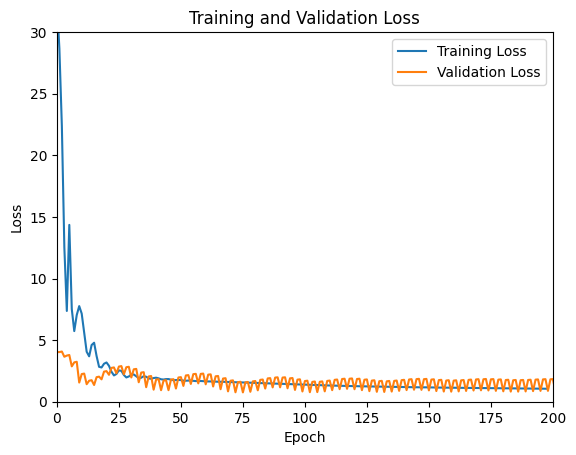

In [78]:
# Graphing training loss vs validation loss vs epoch
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 200)
plt.ylim(0,30)
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
##-> observation, making product embeddings fancier doesn't seem to have done much

In [82]:
def get_product_recommendations(model, data, user_id, total_products):
    user_row = torch.tensor([user_id] * total_products).to(device)
    #print("user row is", user_row)
    all_product_ids = torch.arange(total_products).to(device)
    edge_label_index = torch.stack([user_row, all_product_ids], dim=0)

    pred = model(data.x_dict, data.edge_index_dict, edge_label_index).to('cpu')
    top_five_indices = pred.topk(5).indices

    recommended_products = reviews_df["product_id"].iloc[top_five_indices]
    return recommended_products

In [85]:
rec1 = get_product_recommendations(model, data, 0, len(products))
rec2 = get_product_recommendations(model, data, 2, len(products))
print(rec1)
print("\n")
print(rec2)


739    B000F9Z1WI
862    B000FFRY3G
125    B0002TJAZK
454    B000E7WM0K
693    B000F7PW8S
Name: product_id, dtype: object


739    B000F9Z1WI
862    B000FFRY3G
125    B0002TJAZK
454    B000E7WM0K
693    B000F7PW8S
Name: product_id, dtype: object


In [88]:
#TODO cosine similarity - op on embeddings
#Look into arith. ops on embeddings in general
total_users = len(users)
total_prods = len(products)
prod_recs = []
for user_id in tqdm(range(0, 10)):
    user_row = torch.tensor([user_id] * total_prods)
    all_prod_ids = torch.arange(total_prods)
    edge_label_index = torch.stack([user_row, all_prod_ids], dim=0)
    pred = model(data.x_dict, data.edge_index_dict,
             edge_label_index)
    pred = pred.clamp(min=0, max=5)
    # we will only select products for the user where the predicting rating is > 3.5 
    #TODO understand why 3.5 is important value here; 4 gives empty arrays, 1 gives uniform arrays
    #for example, pred>3.7 is empty arrays for all but user 5 out of 10 users
    rec_prod_ids = (pred > 4.55).nonzero(as_tuple=True)
    top_ten_recs = [rec_prods for rec_prods in rec_prod_ids[0].tolist()[:10]]
    prod_recs.append({'user': user_id, 'rec_products': top_ten_recs})

100%|██████████| 10/10 [00:00<00:00, 55.24it/s]


In [89]:
print(prod_recs)

[{'user': 0, 'rec_products': [0, 1, 2, 4, 5, 6, 9, 10, 12, 14]}, {'user': 1, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'user': 2, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 8, 9, 10]}, {'user': 3, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'user': 4, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'user': 5, 'rec_products': []}, {'user': 6, 'rec_products': []}, {'user': 7, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'user': 8, 'rec_products': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}, {'user': 9, 'rec_products': [125, 454, 693, 739, 862]}]
